In [1]:
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [3]:
df=pd.read_csv("nation_level_daily_latest.csv")
df=df.fillna(method ='pad') 
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,1,1,0,0,0,0
1,31 January,0,1,0,0,0,0
2,01 February,0,1,0,0,0,0
3,02 February,1,2,0,0,0,0
4,03 February,1,3,0,0,0,0


In [4]:
features=["Total Confirmed","Total Recovered","Total Deceased"]
df=df[features]

In [5]:
series=df.values[::]
series=series.astype("float64")
series.shape

(141, 3)

In [6]:
def make_data(series,window_size):
    
    data=[]
    labels=[]

    for i in range(len(series)-window_size):
        temp=series[i:i+window_size+1]
        data.append(temp[:window_size])
        labels.append(temp[window_size:,0])

    return np.array(data),np.array(labels)

In [7]:
split=int(len(series)*0.9)
train_series=series[:split]
test_series=series[split:]

In [8]:
batch_size=32
num_epochs=10000
window_size=7

In [9]:
train_data,train_labels=make_data(train_series,window_size)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset=train_dataset.batch(batch_size)

In [10]:
test_data,test_labels=make_data(test_series,window_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset=test_dataset.batch(batch_size)

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2):
            print("\nCancelling training!")
            self.model.stop_training = True

In [12]:
callbacks = myCallback()

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,activation="relu", return_sequences=True),
    tf.keras.layers.LSTM(128,activation="relu", return_sequences=True),
    tf.keras.layers.GRU(128,activation="relu", return_sequences=True),
    tf.keras.layers.GRU(128,activation="relu", return_sequences=False), 
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])

In [14]:
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=tf.keras.optimizers.Adam())

In [15]:
history = model.fit(train_dataset, epochs=num_epochs,validation_data=test_dataset, callbacks=[callbacks])

Epoch 1/10000
4/4 [==============================] - 1s 146ms/step - loss: 98.9695 - val_loss: 95.4915
Epoch 2/10000
4/4 [==============================] - 0s 33ms/step - loss: 96.8559 - val_loss: 87.8274
Epoch 3/10000
4/4 [==============================] - 0s 37ms/step - loss: 90.9855 - val_loss: 78.1818
Epoch 4/10000
4/4 [==============================] - 0s 36ms/step - loss: 82.5133 - val_loss: 38.1124
Epoch 5/10000
4/4 [==============================] - 0s 35ms/step - loss: 61.9781 - val_loss: 157.6211
Epoch 6/10000
4/4 [==============================] - 0s 36ms/step - loss: 42.0637 - val_loss: 154.6189
Epoch 7/10000
4/4 [==============================] - 0s 36ms/step - loss: 37.6706 - val_loss: 116.6847
Epoch 8/10000
4/4 [==============================] - 0s 78ms/step - loss: 27.7476 - val_loss: 52.4915
Epoch 9/10000
4/4 [==============================] - 0s 35ms/step - loss: 29.1027 - val_loss: 67.4265
Epoch 10/10000
4/4 [==============================] - 0s 38ms/step - loss: 32.

Epoch 81/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.0638 - val_loss: 10.1780
Epoch 82/10000
4/4 [==============================] - 0s 30ms/step - loss: 18.7347 - val_loss: 12.0808
Epoch 83/10000
4/4 [==============================] - 0s 32ms/step - loss: 16.7968 - val_loss: 3.6880
Epoch 84/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.3322 - val_loss: 8.7193
Epoch 85/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.3148 - val_loss: 6.3711
Epoch 86/10000
4/4 [==============================] - 0s 32ms/step - loss: 16.4468 - val_loss: 2.0547
Epoch 87/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.9689 - val_loss: 12.2291
Epoch 88/10000
4/4 [==============================] - 0s 31ms/step - loss: 17.3681 - val_loss: 22.3351
Epoch 89/10000
4/4 [==============================] - 0s 31ms/step - loss: 16.9616 - val_loss: 10.7926
Epoch 90/10000
4/4 [==============================] - 0s 33ms/step - loss: 15

4/4 [==============================] - 0s 33ms/step - loss: 16.7908 - val_loss: 55.3591
Epoch 161/10000
4/4 [==============================] - 0s 31ms/step - loss: 15.1450 - val_loss: 47.6725
Epoch 162/10000
4/4 [==============================] - 0s 32ms/step - loss: 15.8154 - val_loss: 55.6268
Epoch 163/10000
4/4 [==============================] - 0s 33ms/step - loss: 20.6769 - val_loss: 56.5901
Epoch 164/10000
4/4 [==============================] - 0s 33ms/step - loss: 32.2893 - val_loss: 31.6411
Epoch 165/10000
4/4 [==============================] - 0s 31ms/step - loss: 22.5291 - val_loss: 24.2203
Epoch 166/10000
4/4 [==============================] - 0s 31ms/step - loss: 23.7515 - val_loss: 53.2122
Epoch 167/10000
4/4 [==============================] - 0s 32ms/step - loss: 24.3571 - val_loss: 60.0563
Epoch 168/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.4811 - val_loss: 28.5388
Epoch 169/10000
4/4 [==============================] - 0s 32ms/step - loss: 18.6

4/4 [==============================] - 0s 32ms/step - loss: 29.6203 - val_loss: 15.6126
Epoch 240/10000
4/4 [==============================] - 0s 33ms/step - loss: 38.7516 - val_loss: 29.1617
Epoch 241/10000
4/4 [==============================] - 0s 32ms/step - loss: 23.8463 - val_loss: 17.0940
Epoch 242/10000
4/4 [==============================] - 0s 32ms/step - loss: 28.2818 - val_loss: 26.3048
Epoch 243/10000
4/4 [==============================] - 0s 32ms/step - loss: 27.9687 - val_loss: 31.3047
Epoch 244/10000
4/4 [==============================] - 0s 33ms/step - loss: 30.4732 - val_loss: 23.1539
Epoch 245/10000
4/4 [==============================] - 0s 32ms/step - loss: 29.7877 - val_loss: 47.6524
Epoch 246/10000
4/4 [==============================] - 0s 32ms/step - loss: 28.0406 - val_loss: 31.7288
Epoch 247/10000
4/4 [==============================] - 0s 31ms/step - loss: 26.2848 - val_loss: 18.7980
Epoch 248/10000
4/4 [==============================] - 0s 33ms/step - loss: 31.9

4/4 [==============================] - 0s 33ms/step - loss: 17.9066 - val_loss: 15.5703
Epoch 319/10000
4/4 [==============================] - 0s 33ms/step - loss: 15.9949 - val_loss: 6.5375
Epoch 320/10000
4/4 [==============================] - 0s 31ms/step - loss: 19.9458 - val_loss: 10.3356
Epoch 321/10000
4/4 [==============================] - 0s 31ms/step - loss: 16.8295 - val_loss: 1.7365
Epoch 322/10000
4/4 [==============================] - 0s 33ms/step - loss: 15.3632 - val_loss: 7.7327
Epoch 323/10000
4/4 [==============================] - 0s 33ms/step - loss: 18.1942 - val_loss: 2.7102
Epoch 324/10000
4/4 [==============================] - 0s 33ms/step - loss: 15.4960 - val_loss: 2.1197
Epoch 325/10000
4/4 [==============================] - 0s 31ms/step - loss: 17.5884 - val_loss: 11.7925
Epoch 326/10000
4/4 [==============================] - 0s 32ms/step - loss: 17.2983 - val_loss: 2.4327
Epoch 327/10000
4/4 [==============================] - 0s 32ms/step - loss: 18.6745 - 

4/4 [==============================] - 0s 33ms/step - loss: 17.1897 - val_loss: 37.9525
Epoch 398/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.1809 - val_loss: 10.7318
Epoch 399/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.5197 - val_loss: 0.7086
Epoch 400/10000
4/4 [==============================] - 0s 32ms/step - loss: 14.7765 - val_loss: 6.6595
Epoch 401/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.9490 - val_loss: 9.3278
Epoch 402/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.1761 - val_loss: 0.6001
Epoch 403/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.6408 - val_loss: 3.5353
Epoch 404/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.9856 - val_loss: 0.5818
Epoch 405/10000
4/4 [==============================] - 0s 31ms/step - loss: 12.2501 - val_loss: 0.8305
Epoch 406/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.6316 - v

4/4 [==============================] - 0s 30ms/step - loss: 12.2602 - val_loss: 2.8725
Epoch 477/10000
4/4 [==============================] - 0s 35ms/step - loss: 13.9648 - val_loss: 6.9394
Epoch 478/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.7158 - val_loss: 0.7201
Epoch 479/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.8153 - val_loss: 1.3008
Epoch 480/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.8822 - val_loss: 5.6524
Epoch 481/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.6270 - val_loss: 7.2730
Epoch 482/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.8731 - val_loss: 2.9601
Epoch 483/10000
4/4 [==============================] - 0s 35ms/step - loss: 15.2154 - val_loss: 0.5977
Epoch 484/10000
4/4 [==============================] - 0s 31ms/step - loss: 13.2103 - val_loss: 5.7482
Epoch 485/10000
4/4 [==============================] - 0s 33ms/step - loss: 14.6114 - val

4/4 [==============================] - 0s 32ms/step - loss: 13.0905 - val_loss: 6.4755
Epoch 556/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.4879 - val_loss: 1.0112
Epoch 557/10000
4/4 [==============================] - 0s 32ms/step - loss: 14.7541 - val_loss: 1.7131
Epoch 558/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.5036 - val_loss: 2.3525
Epoch 559/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.0890 - val_loss: 4.5084
Epoch 560/10000
4/4 [==============================] - 0s 33ms/step - loss: 15.0905 - val_loss: 11.1300
Epoch 561/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.5410 - val_loss: 10.2729
Epoch 562/10000
4/4 [==============================] - 0s 33ms/step - loss: 15.9661 - val_loss: 24.0290
Epoch 563/10000
4/4 [==============================] - 0s 34ms/step - loss: 15.8661 - val_loss: 11.6340
Epoch 564/10000
4/4 [==============================] - 0s 32ms/step - loss: 16.0948 -

4/4 [==============================] - 0s 34ms/step - loss: 13.3722 - val_loss: 3.8445
Epoch 635/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.5349 - val_loss: 2.5999
Epoch 636/10000
4/4 [==============================] - 0s 31ms/step - loss: 12.1741 - val_loss: 4.3319
Epoch 637/10000
4/4 [==============================] - 0s 32ms/step - loss: 13.0230 - val_loss: 7.6324
Epoch 638/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.7637 - val_loss: 5.2268
Epoch 639/10000
4/4 [==============================] - 0s 32ms/step - loss: 14.3979 - val_loss: 15.5728
Epoch 640/10000
4/4 [==============================] - 0s 33ms/step - loss: 18.0284 - val_loss: 2.0890
Epoch 641/10000
4/4 [==============================] - 0s 31ms/step - loss: 13.0097 - val_loss: 8.8276
Epoch 642/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.6799 - val_loss: 3.8522
Epoch 643/10000
4/4 [==============================] - 0s 34ms/step - loss: 11.2081 - va

4/4 [==============================] - 0s 33ms/step - loss: 12.7405 - val_loss: 3.9975
Epoch 714/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.6406 - val_loss: 5.6796
Epoch 715/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.6085 - val_loss: 7.6005
Epoch 716/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.6881 - val_loss: 3.7138
Epoch 717/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.5827 - val_loss: 8.6625
Epoch 718/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.9585 - val_loss: 4.4339
Epoch 719/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.2573 - val_loss: 0.6446
Epoch 720/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.8379 - val_loss: 2.6111
Epoch 721/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.5112 - val_loss: 0.9810
Epoch 722/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.8427 - val

4/4 [==============================] - 0s 33ms/step - loss: 12.0422 - val_loss: 5.4985
Epoch 793/10000
4/4 [==============================] - 0s 31ms/step - loss: 13.0995 - val_loss: 1.4780
Epoch 794/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.4537 - val_loss: 6.1461
Epoch 795/10000
4/4 [==============================] - 0s 38ms/step - loss: 12.0818 - val_loss: 6.3306
Epoch 796/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.3828 - val_loss: 3.3840
Epoch 797/10000
4/4 [==============================] - 0s 34ms/step - loss: 12.7388 - val_loss: 0.4217
Epoch 798/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.8528 - val_loss: 1.7631
Epoch 799/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.1925 - val_loss: 0.4805
Epoch 800/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.3344 - val_loss: 1.4712
Epoch 801/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.6090 - val

4/4 [==============================] - 0s 30ms/step - loss: 11.6698 - val_loss: 25.9923
Epoch 872/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.0494 - val_loss: 27.1619
Epoch 873/10000
4/4 [==============================] - 0s 34ms/step - loss: 12.2006 - val_loss: 24.6957
Epoch 874/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.7722 - val_loss: 4.8731
Epoch 875/10000
4/4 [==============================] - 0s 31ms/step - loss: 14.3697 - val_loss: 5.6598
Epoch 876/10000
4/4 [==============================] - 0s 32ms/step - loss: 16.1643 - val_loss: 22.8022
Epoch 877/10000
4/4 [==============================] - 0s 33ms/step - loss: 17.6571 - val_loss: 4.0634
Epoch 878/10000
4/4 [==============================] - 0s 31ms/step - loss: 14.8110 - val_loss: 2.5888
Epoch 879/10000
4/4 [==============================] - 0s 31ms/step - loss: 18.6297 - val_loss: 18.7424
Epoch 880/10000
4/4 [==============================] - 0s 31ms/step - loss: 22.0420 

4/4 [==============================] - 0s 33ms/step - loss: 13.4985 - val_loss: 9.2820
Epoch 951/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.7736 - val_loss: 7.9319
Epoch 952/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.8716 - val_loss: 3.7712
Epoch 953/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.7694 - val_loss: 4.0366
Epoch 954/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.3271 - val_loss: 11.4563
Epoch 955/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.5977 - val_loss: 10.0101
Epoch 956/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.9828 - val_loss: 10.6426
Epoch 957/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4044 - val_loss: 12.4548
Epoch 958/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.3291 - val_loss: 8.3445
Epoch 959/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.5144 -

4/4 [==============================] - 0s 32ms/step - loss: 11.7616 - val_loss: 3.5015
Epoch 1030/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.3883 - val_loss: 1.8613
Epoch 1031/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.3153 - val_loss: 5.5639
Epoch 1032/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.9700 - val_loss: 5.4863
Epoch 1033/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.2132 - val_loss: 2.5331
Epoch 1034/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.7290 - val_loss: 1.3332
Epoch 1035/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.3165 - val_loss: 7.2725
Epoch 1036/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.5375 - val_loss: 4.8226
Epoch 1037/10000
4/4 [==============================] - 0s 34ms/step - loss: 11.4927 - val_loss: 1.4281
Epoch 1038/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.6

Epoch 1108/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.4889 - val_loss: 2.9372
Epoch 1109/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.7965 - val_loss: 2.9158
Epoch 1110/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.5124 - val_loss: 5.2449
Epoch 1111/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.0993 - val_loss: 1.6428
Epoch 1112/10000
4/4 [==============================] - 0s 31ms/step - loss: 12.8486 - val_loss: 5.8084
Epoch 1113/10000
4/4 [==============================] - 0s 34ms/step - loss: 13.7365 - val_loss: 8.6540
Epoch 1114/10000
4/4 [==============================] - 0s 35ms/step - loss: 11.2356 - val_loss: 1.8389
Epoch 1115/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.5902 - val_loss: 1.3476
Epoch 1116/10000
4/4 [==============================] - 0s 37ms/step - loss: 12.4392 - val_loss: 2.1350
Epoch 1117/10000
4/4 [==============================] - 0s 39ms/

Epoch 1187/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.9606 - val_loss: 7.1585
Epoch 1188/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.9173 - val_loss: 9.7064
Epoch 1189/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.7271 - val_loss: 3.5928
Epoch 1190/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.1539 - val_loss: 2.6624
Epoch 1191/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.4870 - val_loss: 5.7447
Epoch 1192/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.7264 - val_loss: 4.2166
Epoch 1193/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.8638 - val_loss: 7.2159
Epoch 1194/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.2828 - val_loss: 5.3969
Epoch 1195/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9869 - val_loss: 7.0034
Epoch 1196/10000
4/4 [==============================] - 0s 32ms/s

Epoch 1266/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.8530 - val_loss: 10.4906
Epoch 1267/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.6008 - val_loss: 1.5925
Epoch 1268/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9228 - val_loss: 2.6852
Epoch 1269/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.1443 - val_loss: 7.0908
Epoch 1270/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.7411 - val_loss: 4.6964
Epoch 1271/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.8999 - val_loss: 4.2276
Epoch 1272/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.4484 - val_loss: 4.0647
Epoch 1273/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.7092 - val_loss: 13.4111
Epoch 1274/10000
4/4 [==============================] - 0s 36ms/step - loss: 11.0177 - val_loss: 5.4494
Epoch 1275/10000
4/4 [==============================] - 0s 33ms

Epoch 1345/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.7300 - val_loss: 1.8284
Epoch 1346/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.1692 - val_loss: 7.2405
Epoch 1347/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.8274 - val_loss: 2.5707
Epoch 1348/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4004 - val_loss: 0.5531
Epoch 1349/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.2036 - val_loss: 8.1913
Epoch 1350/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.2021 - val_loss: 5.8192
Epoch 1351/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.6045 - val_loss: 1.5174
Epoch 1352/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.0420 - val_loss: 9.0448
Epoch 1353/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.8709 - val_loss: 11.0237
Epoch 1354/10000
4/4 [==============================] - 0s 33ms/st

Epoch 1424/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.6638 - val_loss: 2.7732
Epoch 1425/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.9634 - val_loss: 7.0603
Epoch 1426/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.3311 - val_loss: 7.7031
Epoch 1427/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.0759 - val_loss: 1.6122
Epoch 1428/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.2674 - val_loss: 6.6434
Epoch 1429/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5769 - val_loss: 4.5723
Epoch 1430/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9480 - val_loss: 1.6766
Epoch 1431/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.2379 - val_loss: 2.4377
Epoch 1432/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.6833 - val_loss: 5.1202
Epoch 1433/10000
4/4 [==============================] - 0s 32ms/step

Epoch 1503/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.7933 - val_loss: 0.5219
Epoch 1504/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4773 - val_loss: 9.3445
Epoch 1505/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.2345 - val_loss: 3.8691
Epoch 1506/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.8284 - val_loss: 0.5257
Epoch 1507/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.0699 - val_loss: 2.5173
Epoch 1508/10000
4/4 [==============================] - 0s 31ms/step - loss: 12.2904 - val_loss: 5.0855
Epoch 1509/10000
4/4 [==============================] - 0s 35ms/step - loss: 10.7723 - val_loss: 2.8920
Epoch 1510/10000
4/4 [==============================] - 0s 35ms/step - loss: 9.8006 - val_loss: 6.2742
Epoch 1511/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.5726 - val_loss: 4.1626
Epoch 1512/10000
4/4 [==============================] - 0s 35ms/s

Epoch 1582/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9654 - val_loss: 7.3170
Epoch 1583/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.5315 - val_loss: 7.2038
Epoch 1584/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8409 - val_loss: 4.7888
Epoch 1585/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.0734 - val_loss: 7.7541
Epoch 1586/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.0522 - val_loss: 5.4243
Epoch 1587/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.1982 - val_loss: 4.5369
Epoch 1588/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.1072 - val_loss: 7.2408
Epoch 1589/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.1010 - val_loss: 4.5914
Epoch 1590/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.4947 - val_loss: 4.4120
Epoch 1591/10000
4/4 [==============================] - 0s 33ms/ste

Epoch 1661/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.5792 - val_loss: 2.2593
Epoch 1662/10000
4/4 [==============================] - 0s 34ms/step - loss: 11.3624 - val_loss: 11.1014
Epoch 1663/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.4091 - val_loss: 8.4665
Epoch 1664/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.3529 - val_loss: 2.5331
Epoch 1665/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.0706 - val_loss: 10.3190
Epoch 1666/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.7991 - val_loss: 14.8277
Epoch 1667/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.4094 - val_loss: 2.5892
Epoch 1668/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.6123 - val_loss: 1.3366
Epoch 1669/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4408 - val_loss: 14.7146
Epoch 1670/10000
4/4 [==============================] - 0s 3

Epoch 1740/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.1499 - val_loss: 0.6586
Epoch 1741/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5034 - val_loss: 1.5123
Epoch 1742/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.4712 - val_loss: 0.9731
Epoch 1743/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.6571 - val_loss: 0.5149
Epoch 1744/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8833 - val_loss: 2.2470
Epoch 1745/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.0486 - val_loss: 3.6832
Epoch 1746/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.9628 - val_loss: 3.5895
Epoch 1747/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.7792 - val_loss: 3.6220
Epoch 1748/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.6616 - val_loss: 1.7799
Epoch 1749/10000
4/4 [==============================] - 0s 32ms/step 

Epoch 1819/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.6158 - val_loss: 5.0916
Epoch 1820/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.1737 - val_loss: 1.2581
Epoch 1821/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.4893 - val_loss: 7.0451
Epoch 1822/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.8769 - val_loss: 6.6486
Epoch 1823/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.2645 - val_loss: 6.7179
Epoch 1824/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.9377 - val_loss: 1.4734
Epoch 1825/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.9870 - val_loss: 1.5432
Epoch 1826/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.5443 - val_loss: 5.1935
Epoch 1827/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.6242 - val_loss: 7.8786
Epoch 1828/10000
4/4 [==============================] - 0s 33ms/step 

4/4 [==============================] - 0s 34ms/step - loss: 10.4849 - val_loss: 4.8922
Epoch 1899/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.8520 - val_loss: 0.4794
Epoch 1900/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1027 - val_loss: 2.4715
Epoch 1901/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4272 - val_loss: 0.5242
Epoch 1902/10000
4/4 [==============================] - 0s 31ms/step - loss: 11.1202 - val_loss: 1.5831
Epoch 1903/10000
4/4 [==============================] - 0s 33ms/step - loss: 12.2318 - val_loss: 1.2655
Epoch 1904/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5749 - val_loss: 5.9434
Epoch 1905/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.1315 - val_loss: 6.3433
Epoch 1906/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.0533 - val_loss: 0.4576
Epoch 1907/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.6153

4/4 [==============================] - 0s 32ms/step - loss: 9.8486 - val_loss: 1.7641
Epoch 1978/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4284 - val_loss: 1.0252
Epoch 1979/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.5018 - val_loss: 2.2164
Epoch 1980/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.2325 - val_loss: 1.5894
Epoch 1981/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.2881 - val_loss: 0.6640
Epoch 1982/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9057 - val_loss: 0.8791
Epoch 1983/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9537 - val_loss: 2.8846
Epoch 1984/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.1335 - val_loss: 0.7436
Epoch 1985/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.8600 - val_loss: 2.0902
Epoch 1986/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.3307 -

4/4 [==============================] - 0s 35ms/step - loss: 9.8539 - val_loss: 1.0696
Epoch 2057/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8578 - val_loss: 0.9022
Epoch 2058/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8778 - val_loss: 6.0764
Epoch 2059/10000
4/4 [==============================] - 0s 36ms/step - loss: 10.4610 - val_loss: 3.4921
Epoch 2060/10000
4/4 [==============================] - 0s 37ms/step - loss: 9.7929 - val_loss: 4.5133
Epoch 2061/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.9455 - val_loss: 7.4436
Epoch 2062/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1970 - val_loss: 1.8143
Epoch 2063/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.0712 - val_loss: 2.1542
Epoch 2064/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8418 - val_loss: 0.8409
Epoch 2065/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.4376 - va

4/4 [==============================] - 0s 33ms/step - loss: 9.5259 - val_loss: 0.6021
Epoch 2136/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.1458 - val_loss: 1.4386
Epoch 2137/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1093 - val_loss: 4.8657
Epoch 2138/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.8794 - val_loss: 3.5335
Epoch 2139/10000
4/4 [==============================] - 0s 35ms/step - loss: 9.9771 - val_loss: 4.1024
Epoch 2140/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.2314 - val_loss: 0.9198
Epoch 2141/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.2059 - val_loss: 1.1155
Epoch 2142/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.0734 - val_loss: 1.7847
Epoch 2143/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.7836 - val_loss: 3.4084
Epoch 2144/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.2373 - v

4/4 [==============================] - 0s 33ms/step - loss: 9.6801 - val_loss: 6.5593
Epoch 2215/10000
4/4 [==============================] - 0s 34ms/step - loss: 10.3879 - val_loss: 5.2462
Epoch 2216/10000
4/4 [==============================] - 0s 33ms/step - loss: 13.7113 - val_loss: 1.3017
Epoch 2217/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.0058 - val_loss: 6.8495
Epoch 2218/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.8550 - val_loss: 1.4230
Epoch 2219/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.4177 - val_loss: 9.5050
Epoch 2220/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.1942 - val_loss: 0.6930
Epoch 2221/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.4646 - val_loss: 4.7724
Epoch 2222/10000
4/4 [==============================] - 0s 34ms/step - loss: 10.1273 - val_loss: 3.4492
Epoch 2223/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.195

4/4 [==============================] - 0s 33ms/step - loss: 12.1535 - val_loss: 16.9327
Epoch 2294/10000
4/4 [==============================] - 0s 31ms/step - loss: 8.8034 - val_loss: 1.8805
Epoch 2295/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.3438 - val_loss: 3.5708
Epoch 2296/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.8995 - val_loss: 6.3355
Epoch 2297/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.6439 - val_loss: 2.3827
Epoch 2298/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.6778 - val_loss: 0.7279
Epoch 2299/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.9406 - val_loss: 2.7320
Epoch 2300/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8041 - val_loss: 5.3049
Epoch 2301/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.1543 - val_loss: 1.0405
Epoch 2302/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.9812 

4/4 [==============================] - 0s 34ms/step - loss: 9.3825 - val_loss: 1.6026
Epoch 2373/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.0022 - val_loss: 0.5428
Epoch 2374/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.8626 - val_loss: 3.4215
Epoch 2375/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.9592 - val_loss: 0.9271
Epoch 2376/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.7158 - val_loss: 3.6254
Epoch 2377/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.9859 - val_loss: 6.1943
Epoch 2378/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.5404 - val_loss: 4.2108
Epoch 2379/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.0843 - val_loss: 2.5043
Epoch 2380/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.0308 - val_loss: 2.0850
Epoch 2381/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.6978 - v

4/4 [==============================] - 0s 35ms/step - loss: 9.7773 - val_loss: 4.4246
Epoch 2452/10000
4/4 [==============================] - 0s 36ms/step - loss: 10.1122 - val_loss: 3.0413
Epoch 2453/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.5924 - val_loss: 1.6023
Epoch 2454/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.1286 - val_loss: 4.6513
Epoch 2455/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.9309 - val_loss: 5.2565
Epoch 2456/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.9855 - val_loss: 0.6041
Epoch 2457/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.7646 - val_loss: 1.8350
Epoch 2458/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.4587 - val_loss: 2.8606
Epoch 2459/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.2426 - val_loss: 3.2098
Epoch 2460/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.5743 - v

4/4 [==============================] - 0s 33ms/step - loss: 8.5766 - val_loss: 0.3117
Epoch 2531/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.2812 - val_loss: 0.4434
Epoch 2532/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.8836 - val_loss: 1.1254
Epoch 2533/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.4885 - val_loss: 4.6837
Epoch 2534/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.0999 - val_loss: 1.6422
Epoch 2535/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.5691 - val_loss: 7.2849
Epoch 2536/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.0198 - val_loss: 0.4268
Epoch 2537/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.2344 - val_loss: 2.3381
Epoch 2538/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.0922 - val_loss: 7.6938
Epoch 2539/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7323 - va

4/4 [==============================] - 0s 33ms/step - loss: 8.8759 - val_loss: 2.0855
Epoch 2610/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8566 - val_loss: 0.3534
Epoch 2611/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.1343 - val_loss: 1.7424
Epoch 2612/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1579 - val_loss: 0.7517
Epoch 2613/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.4735 - val_loss: 3.6872
Epoch 2614/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.4664 - val_loss: 4.0959
Epoch 2615/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.2547 - val_loss: 2.9161
Epoch 2616/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.1622 - val_loss: 1.7584
Epoch 2617/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.7626 - val_loss: 3.7254
Epoch 2618/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.3255 - val

4/4 [==============================] - 0s 33ms/step - loss: 8.3614 - val_loss: 0.7843
Epoch 2689/10000
4/4 [==============================] - 0s 35ms/step - loss: 10.6185 - val_loss: 0.3106
Epoch 2690/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.4393 - val_loss: 0.7896
Epoch 2691/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.2860 - val_loss: 0.3680
Epoch 2692/10000
4/4 [==============================] - 0s 35ms/step - loss: 8.6111 - val_loss: 2.5293
Epoch 2693/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.1511 - val_loss: 1.6577
Epoch 2694/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5170 - val_loss: 3.4662
Epoch 2695/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6322 - val_loss: 2.4839
Epoch 2696/10000
4/4 [==============================] - 0s 32ms/step - loss: 11.2607 - val_loss: 3.2693
Epoch 2697/10000
4/4 [==============================] - 0s 33ms/step - loss: 11.0012 - 

4/4 [==============================] - 0s 33ms/step - loss: 8.9483 - val_loss: 4.9337
Epoch 2768/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3231 - val_loss: 3.9578
Epoch 2769/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.5943 - val_loss: 0.8778
Epoch 2770/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.1170 - val_loss: 3.6317
Epoch 2771/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5602 - val_loss: 1.0842
Epoch 2772/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5264 - val_loss: 1.2744
Epoch 2773/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.4443 - val_loss: 2.3604
Epoch 2774/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6773 - val_loss: 3.4919
Epoch 2775/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.6336 - val_loss: 0.7896
Epoch 2776/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.8339 - val_

4/4 [==============================] - 0s 33ms/step - loss: 9.1970 - val_loss: 3.3851
Epoch 2847/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3927 - val_loss: 5.4297
Epoch 2848/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.5366 - val_loss: 0.3358
Epoch 2849/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.3642 - val_loss: 0.6110
Epoch 2850/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.7689 - val_loss: 0.4881
Epoch 2851/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.3102 - val_loss: 4.0424
Epoch 2852/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.6927 - val_loss: 1.9898
Epoch 2853/10000
4/4 [==============================] - 0s 39ms/step - loss: 8.5113 - val_loss: 2.3544
Epoch 2854/10000
4/4 [==============================] - 0s 36ms/step - loss: 10.0603 - val_loss: 2.1728
Epoch 2855/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4142 - val

4/4 [==============================] - 0s 31ms/step - loss: 10.1840 - val_loss: 1.0975
Epoch 2926/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4620 - val_loss: 1.3648
Epoch 2927/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.0478 - val_loss: 2.0934
Epoch 2928/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8609 - val_loss: 2.5187
Epoch 2929/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.8722 - val_loss: 5.2931
Epoch 2930/10000
4/4 [==============================] - 0s 33ms/step - loss: 10.6184 - val_loss: 3.7716
Epoch 2931/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.5943 - val_loss: 1.1668
Epoch 2932/10000
4/4 [==============================] - 0s 35ms/step - loss: 11.6637 - val_loss: 0.2471
Epoch 2933/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7646 - val_loss: 5.0063
Epoch 2934/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1679 - v

4/4 [==============================] - 0s 33ms/step - loss: 9.7113 - val_loss: 3.4767
Epoch 3005/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.4314 - val_loss: 3.9250
Epoch 3006/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4942 - val_loss: 1.7240
Epoch 3007/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.0175 - val_loss: 0.6662
Epoch 3008/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8155 - val_loss: 2.9124
Epoch 3009/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.6334 - val_loss: 3.1433
Epoch 3010/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.5715 - val_loss: 1.5915
Epoch 3011/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.9508 - val_loss: 1.3445
Epoch 3012/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8120 - val_loss: 2.8496
Epoch 3013/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.8913 - val

4/4 [==============================] - 0s 34ms/step - loss: 9.2726 - val_loss: 6.1092
Epoch 3084/10000
4/4 [==============================] - 0s 35ms/step - loss: 9.6197 - val_loss: 1.7749
Epoch 3085/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.8820 - val_loss: 0.6764
Epoch 3086/10000
4/4 [==============================] - 0s 31ms/step - loss: 8.4248 - val_loss: 8.1210
Epoch 3087/10000
4/4 [==============================] - 0s 34ms/step - loss: 10.5530 - val_loss: 3.9839
Epoch 3088/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.6680 - val_loss: 6.6850
Epoch 3089/10000
4/4 [==============================] - 0s 32ms/step - loss: 12.1278 - val_loss: 3.1177
Epoch 3090/10000
4/4 [==============================] - 0s 36ms/step - loss: 8.4432 - val_loss: 5.8061
Epoch 3091/10000
4/4 [==============================] - 0s 36ms/step - loss: 8.1219 - val_loss: 7.7707
Epoch 3092/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.7985 - va

4/4 [==============================] - 0s 34ms/step - loss: 8.9511 - val_loss: 0.4019
Epoch 3163/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.6477 - val_loss: 1.8733
Epoch 3164/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5731 - val_loss: 0.2295
Epoch 3165/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.2859 - val_loss: 1.2591
Epoch 3166/10000
4/4 [==============================] - 0s 35ms/step - loss: 9.5826 - val_loss: 1.2961
Epoch 3167/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.4791 - val_loss: 2.5126
Epoch 3168/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.6150 - val_loss: 3.5037
Epoch 3169/10000
4/4 [==============================] - 0s 35ms/step - loss: 8.1478 - val_loss: 0.6499
Epoch 3170/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.3768 - val_loss: 0.9379
Epoch 3171/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.2549 - val

4/4 [==============================] - 0s 36ms/step - loss: 9.2216 - val_loss: 2.8864
Epoch 3242/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.4804 - val_loss: 1.0523
Epoch 3243/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.7753 - val_loss: 3.8232
Epoch 3244/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.1007 - val_loss: 10.7074
Epoch 3245/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8151 - val_loss: 5.2115
Epoch 3246/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7221 - val_loss: 0.7824
Epoch 3247/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.5907 - val_loss: 0.7413
Epoch 3248/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.7430 - val_loss: 5.8733
Epoch 3249/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6921 - val_loss: 6.8417
Epoch 3250/10000
4/4 [==============================] - 0s 32ms/step - loss: 10.2290 - va

4/4 [==============================] - 0s 34ms/step - loss: 8.6150 - val_loss: 6.8033
Epoch 3321/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.4489 - val_loss: 6.4883
Epoch 3322/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.5659 - val_loss: 5.7318
Epoch 3323/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.8241 - val_loss: 6.5268
Epoch 3324/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.1811 - val_loss: 6.0865
Epoch 3325/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.9665 - val_loss: 3.3219
Epoch 3326/10000
4/4 [==============================] - 0s 32ms/step - loss: 7.4193 - val_loss: 0.2071
Epoch 3327/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8910 - val_loss: 1.2909
Epoch 3328/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.1564 - val_loss: 5.1283
Epoch 3329/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.7427 - val_

4/4 [==============================] - 0s 34ms/step - loss: 9.3220 - val_loss: 1.0847
Epoch 3400/10000
4/4 [==============================] - 0s 31ms/step - loss: 10.1405 - val_loss: 0.2201
Epoch 3401/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1119 - val_loss: 1.2978
Epoch 3402/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.3974 - val_loss: 0.8651
Epoch 3403/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.1481 - val_loss: 2.3041
Epoch 3404/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.8790 - val_loss: 2.0457
Epoch 3405/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.0539 - val_loss: 0.2263
Epoch 3406/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.1785 - val_loss: 2.3958
Epoch 3407/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.2014 - val_loss: 1.4390
Epoch 3408/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.8242 - val

4/4 [==============================] - 0s 33ms/step - loss: 10.0594 - val_loss: 2.0843
Epoch 3479/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.7251 - val_loss: 1.1493
Epoch 3480/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3655 - val_loss: 5.9764
Epoch 3481/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7354 - val_loss: 4.6629
Epoch 3482/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3482 - val_loss: 0.7630
Epoch 3483/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.7403 - val_loss: 0.2557
Epoch 3484/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.0508 - val_loss: 2.1782
Epoch 3485/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.5957 - val_loss: 2.4511
Epoch 3486/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.9322 - val_loss: 3.2634
Epoch 3487/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.9759 - val

4/4 [==============================] - 0s 37ms/step - loss: 8.9464 - val_loss: 3.3409
Epoch 3558/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8855 - val_loss: 0.5704
Epoch 3559/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.5374 - val_loss: 3.5411
Epoch 3560/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.8635 - val_loss: 4.4300
Epoch 3561/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.0756 - val_loss: 2.9985
Epoch 3562/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.2384 - val_loss: 2.2091
Epoch 3563/10000
4/4 [==============================] - 0s 35ms/step - loss: 10.1786 - val_loss: 4.9249
Epoch 3564/10000
4/4 [==============================] - 0s 37ms/step - loss: 7.5090 - val_loss: 6.1878
Epoch 3565/10000
4/4 [==============================] - 0s 37ms/step - loss: 9.0941 - val_loss: 3.9741
Epoch 3566/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.3486 - val

4/4 [==============================] - 0s 38ms/step - loss: 8.1656 - val_loss: 0.2468
Epoch 3637/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.9301 - val_loss: 1.5988
Epoch 3638/10000
4/4 [==============================] - 0s 31ms/step - loss: 9.3469 - val_loss: 0.3968
Epoch 3639/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4575 - val_loss: 0.5481
Epoch 3640/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7973 - val_loss: 0.6548
Epoch 3641/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8266 - val_loss: 0.2396
Epoch 3642/10000
4/4 [==============================] - 0s 35ms/step - loss: 8.1280 - val_loss: 3.0536
Epoch 3643/10000
4/4 [==============================] - 0s 34ms/step - loss: 9.7497 - val_loss: 5.0634
Epoch 3644/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.5814 - val_loss: 4.2625
Epoch 3645/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.5380 - val_

4/4 [==============================] - 0s 31ms/step - loss: 8.0813 - val_loss: 1.0017
Epoch 3716/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3922 - val_loss: 2.5765
Epoch 3717/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.8604 - val_loss: 0.8048
Epoch 3718/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.3386 - val_loss: 3.6851
Epoch 3719/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6486 - val_loss: 7.0312
Epoch 3720/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.7214 - val_loss: 6.3254
Epoch 3721/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.2324 - val_loss: 2.7000
Epoch 3722/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.4899 - val_loss: 1.1098
Epoch 3723/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.5730 - val_loss: 0.6975
Epoch 3724/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.8112 - val_

4/4 [==============================] - 0s 32ms/step - loss: 8.7844 - val_loss: 2.5977
Epoch 3795/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7566 - val_loss: 3.3164
Epoch 3796/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.5072 - val_loss: 3.8061
Epoch 3797/10000
4/4 [==============================] - 0s 32ms/step - loss: 9.2665 - val_loss: 6.6574
Epoch 3798/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.0931 - val_loss: 6.4568
Epoch 3799/10000
4/4 [==============================] - 0s 33ms/step - loss: 7.6703 - val_loss: 7.2068
Epoch 3800/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.6340 - val_loss: 4.7541
Epoch 3801/10000
4/4 [==============================] - 0s 34ms/step - loss: 8.4387 - val_loss: 1.0651
Epoch 3802/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.2874 - val_loss: 1.0559
Epoch 3803/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.7257 - val_

4/4 [==============================] - 0s 33ms/step - loss: 9.8140 - val_loss: 2.1223
Epoch 3874/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.2995 - val_loss: 1.4004
Epoch 3875/10000
4/4 [==============================] - 0s 33ms/step - loss: 9.7197 - val_loss: 1.1952
Epoch 3876/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.6617 - val_loss: 7.1532
Epoch 3877/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.3175 - val_loss: 4.8098
Epoch 3878/10000
4/4 [==============================] - 0s 34ms/step - loss: 7.7986 - val_loss: 0.7865
Epoch 3879/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6803 - val_loss: 0.6189
Epoch 3880/10000
4/4 [==============================] - 0s 33ms/step - loss: 8.6742 - val_loss: 6.1629
Epoch 3881/10000
4/4 [==============================] - 0s 32ms/step - loss: 8.8275 - val_loss: 5.0986
Epoch 3882/10000
4/4 [==============================] - 0s 35ms/step - loss: 8.4883 - val_

In [16]:
pred=model.predict(test_data)
pred.shape

(8, 1)

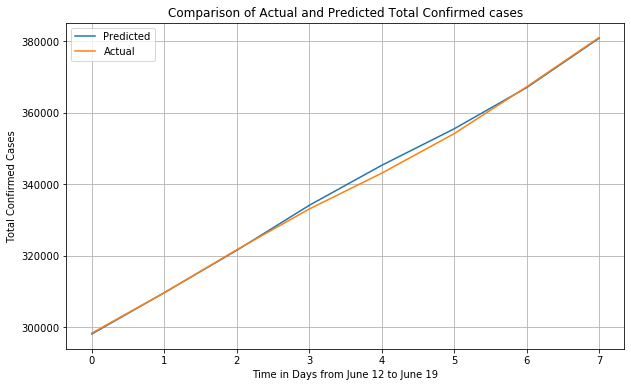

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(pred,label="Predicted")
plt.plot(test_labels,label="Actual")
plt.xlabel("Time in Days from June 12 to June 19")
plt.ylabel("Total Confirmed Cases")
plt.legend()
plt.title("Comparison of Actual and Predicted Total Confirmed cases")
plt.grid(True)
plt.show()
plt.savefig("LSTM-GRU-National-Result.png")

In [18]:
tf.keras.metrics.mean_absolute_percentage_error(test_labels,pred).numpy().mean()

0.19846698638404656

In [19]:
# tf.keras.models.save_model(model,'saved_model/national_model',save_format='h5') 